<a href="https://colab.research.google.com/github/nf-exphys/AJP-Endo-MetFlex-Body-Fat/blob/main/AJP_Endo_MetFlex_Body_Fat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis for Postprandial MetFlex Paper
The code in this script should produce all plots and tables needed for the analyses in our paper "*Increased Postprandial Metabolic Flexibility is Associated with Higher Body Fat Percentages in Healthy Young Adults*". To run the whole script on your own, you must do two things:


1.   Download the analysis.zip folder from the GitHub here (link to be added soon).
2.   Click the folder icon to the left (underneath the key icon).
3.   Click the icon of a page with the corner folded over (labeled "Upload to session storage"). In the pop-up window, navigate to wherever you've saved the analysis.zip folder on your computer and select it for upload.
4. Click "Run All" above.

Unfortunately, this first step takes about 15 minutes, because it takes a long time to load the libraries. Everything after that is relatively quick (<1 min).

# Load Libraries and Functions

In [ ]:
#these are the packages needed to run the script
  #unfortunately, running this cell takes ~15 minutes

packages <- c("tidyverse", "lmerTest", "tidyverse",
              "emmeans", "papaja", "gtsummary", "gt",
              "googledrive", "janitor", "tableone",
              "Hmisc", "labelled",
              "pbkrtest", "plyr",
              "IRdisplay",
              "parameters",
              "writexl",
              "ggprism",
              "broom.helpers",
              "broom.mixed",
              "extrafont")

#Compares the installed packages to the ones needed
  #this comparison is important to avoid unnecessarily re-installing packages
pkg_installed <- as.data.frame(installed.packages())
pkg_needed <- packages[!(packages %in% pkg_installed$Package)]

#installs needed packages
if(!requireNamespace(any(pkg_needed), quietly = T)){
lapply(pkg_needed, install.packages)
}

library(tidyverse); library(lmerTest); library(emmeans); library(papaja)
library(gtsummary); library(gt); library(googledrive); library(janitor)
library(extrafont)

list()

In [ ]:
#unzip the analysis folder
if (file.exists("./analysis.zip")) {
unzip("./analysis.zip", exdir = "./analysis")
} else{
  stop("You need to upload the analysis.zip folder. Scroll up and try again.")
}


In [14]:
#for now, click the folder icon and upload a folder with data files. Make sure the folder is called analysis
analysis <- read_csv("./analysis/postprandial_analysis.csv", show_col_types = F) %>%
  mutate(id = as.factor(id),sex = as.factor(sex))

labelled::var_label(analysis) <- list(
  rer_0 = "Fasting Measure",
  cho_0 = "Fasting Measure",
  fat_0 = "Fasting Measure",
  nefa_0 = "Fasting Measure",
  insulin_0 = "Fasting Measure",
  glucose_0 = "Fasting Measure",
  time = "Time",
  percent_fat = "BF%",
  fat_mass = "Fat Mass",
  ffm = "Fat-free Mass",
  vat_vol_trfm = "VAT volume^(1/3)",
  sex = "Sex (Male)", #female is reference level
  age_yrs = "Age",
  bmi = "BMI",
  adip_ir_ogtt = "AdipIR (OGTT)",
  matsuda = "Matsuda"
)

#read in supporting ancillary data
other_data <- read_csv("./analysis/other_data.csv", show_col_types = F)

#read in data on transformation using mean/SD
mean_sds <- read_csv("./analysis/analytic_sample_mean_sd.csv", show_col_types = F) %>%
  rename(mean = ref_means,
         sd = ref_sd)


In [15]:
#Create functions
decide_interaction <- function(model_obj){

  #in this model, all that matters is the interaction terms
  pval_int <- summary(model_obj)["coefficients"] %>%
    data.frame() %>%
    rownames_to_column(., "term") %>%
    filter(grepl(":", term)) %>%
    select(contains("p")) %>%
    pull()

  #if one of the interactions is significant, return the model
  if(any(pval_int < 0.05)){
    print("Significant interaction. Returning model for plotting")
    return(list(pval_int = pval_int, mod = model_obj))

  } else{

    #remove interaction
    final_form <- str_replace_all(
      as.character(formula(model_obj))[3], #covars from first model
      "\\*", "+") %>%
      paste(as.character(formula(model_obj))[2], #outcome var from first model
            "~",
            .,
            collapse = "") %>%
      as.formula(.)

    #fit model
    final_model <- lmer(final_form, data = analysis)
    print("No interaction. Returning reduced model")
    return(list(pval_int = pval_int, mod = final_model, quad_mod = model_obj))

  }
}

#make function to get mean and SD for AUC data
m_sd <- function(x){
  #col mean
  m <- mean(x, na.rm = T)

  if(m > 1000){
    n_round <- -1
    m <- round(m, n_round)
  } else{
    n_round <- 1
    m <- round(m, n_round)
  }

  s <- sd(x, na.rm = T)
  if(s < 100){
    s <- round(s, 1)
  } else{
    s <- round(s, 0)
  }

    return(paste0(m, " ± ", s))
    }

#create function to compare between linear and quadratic models
linear_quad_models <- function(adiposity, outcome, baseline, ffm = F, simple_covars = F){

  linear <- paste("time * ", adiposity, collapse = "")
  quad <- paste("I(time^2) * ", adiposity, " + ", linear, collapse = "")

  #reviewer interest in limiting number of covariates
  if(simple_covars == T){
    covars <- paste("+", baseline, "+",
    "sex + matsuda + (1|id)",
    collapse = "")
  } else{
    covars <- paste("+", baseline, "+",
    "sex + age_yrs + matsuda + adip_ir_ogtt + vat_vol_trfm + (1|id)",
    collapse = "")
  }

  #set ffm to True to add as an additional covariate
  if(ffm == T){
    covars <- paste(covars, "+", "ffm", collapse = "")
  }

  linear_form <- as.formula(paste(outcome, " ~ ", linear, covars, collapse = ""))

  quad_form <- as.formula(paste(outcome, " ~ ", quad, covars, collapse = ""))

  #fit linear model
  linear_model <- lmer(linear_form, data = analysis)

  #fit quadratic model
  quad_model <- lmer(quad_form, data = analysis)

  #Compare the two models and determine the best fit to the data
  model_comp_res <- anova(linear_model, quad_model, test = "LRT") %>%
    data.frame() %>%
    rename(p_val = `Pr..Chisq.`)

  comp_pval <- model_comp_res %>%
    drop_na(p_val) %>%
    pull(p_val)

  comp_pval <- round(comp_pval, 3)

  #quadratic is better than linear
  if(comp_pval < 0.050){

    print(paste0("Quadratic model selected, p = ", comp_pval))

    return(list(p_comp = comp_pval,
                mod = decide_interaction(quad_model),
                comp_res = model_comp_res))
  }

  #linear is better than quadratic
  if(comp_pval > 0.050){

    print(paste0("Linear model selected, p = ", comp_pval))

    return(list(p_comp = comp_pval,
                mod = decide_interaction(linear_model),
                comp_res = model_comp_res))
  }



}

#takes dataframe from model comparison and assembles Chi-sq stats in APA format
format_chisq_res <- function(comp_res, full_res = F){
  # browser()
  if(is.data.frame(comp_res)){
    #drop NA to reduce down to one row for easier report
    res <- drop_na(comp_res)

    #if reporting full Chi-sq results
    if(full_res){

      #get full Chi-sq results
      chisq_text <- paste0("(χ^2^(df=", res$Df, ") = ", apa_num(res$Chisq), ",")

      if(res$p_val < 0.001){
      chisq_text <- paste0(chisq_text, "p ",
                           apa_num(res$p_val, digits = 3, zero = F),
                           ")")
    } else{
       chisq_text <- paste0(chisq_text, "p=",
                           apa_num(res$p_val, digits = 3, zero = F),
                           ")")
    }
    } else{

      #return just the p-value (default)
      if(res$p_val < 0.001){
      chisq_text <- paste0("(p ",apa_num(res$p_val, digits = 3, zero = F),")")
    } else{
       chisq_text <- paste0("(p=", apa_num(res$p_val, digits = 3, zero = F),")")
    }
    }


    return(chisq_text)

  }else{stop("Model comp must be passed as a dataframe")}

}

#function to return only the pvalue from model results
mod_p <- function(mod_res){
  # browser()

  #if pvalue is already formatted, just set p_val to <0.001
  if(str_detect(mod_res, "p < .001")){
    p_val <- "p < 0.001"
  } else{
    p <- str_extract(mod_res,
                       regex("(?<=\\$p = )(\\.\\d{3,4})")) %>%
    as.numeric(.) %>%
    format.pval(.)
    p_val <- paste0("p = ", p)
  }

  return(p_val)
}

#calculates AUC using the trapezoidal rule
  #for now, this may only work when used within summarize?
trap_rule <- function(df = pick(everything()), var = "var", delta_t = 30){

  #f(x0) + f(xn)
  sum_0_120 <- sum(df[[var]][df$time == 0], df[[var]][df$time == 120])

  #sum of f(x1) to f(xn-1), all times 2
  sum_30_60_90 <- 2 * sum(df[[var]][df$time %in% c(30, 60, 90)])

  # 1/2*delta_x * [f(x0) to f(xn)]
  auc <- (sum_0_120 + sum_30_60_90)*(delta_t/2)

  return(auc)
}

ogtt_change <- function(outcome_var){

  my_formula <- as.formula(paste0(outcome_var, " ~ factor(time) + (1|id)"))
  outcome_model <- lmer(my_formula, data = unstd_analysis)

  emm <- emmeans::emmeans(outcome_model, "time")

  #make outcome variable all caps for formatting
  upper_var <- toupper(outcome_var)

  #compare postprandial vs. baseline and return pval
  p_vs_bsl <- emm %>%
    emmeans::contrast(., 'trt.vs.ctrl', adjust = 'sidak') %>%
    broom::tidy() %>%
      #needs plyr::round_any because back converting time doesn't get to *exactly* 30,60,90,120
    mutate(Time = plyr::round_any(as.numeric(str_extract(contrast, "\\d{2,3}")), accuracy = 30),
           p_val = format.pval(adj.p.value, digits = 3, eps = 0.001),
           #rounding pval when it's not <0.001, warns about NAs but works correctly?
           p_val = suppressWarnings(case_when(grepl("<", p_val) ~ p_val,
           !grepl("<", p_val) ~ as.character(round(as.numeric(p_val), 3))))
           ) %>%
    select(Time, p_val)

  #set up results table
  suppressWarnings(res_table <- ogtt_means %>%
    select(time, matches(outcome_var)) %>%
    rename(Time = time, !!sym(upper_var) := sym(outcome_var)) %>%
    mutate(Time = plyr::round_any(as.numeric(Time), 30)) %>%
    left_join(., p_vs_bsl, by = "Time") %>%
    mutate(out = glue::glue("{.data[[upper_var]]} (p = {p_val})")) %>%
    mutate(out = str_remove(glue::glue("{out}"), "\\(p = NA\\)"),
           out = str_replace(glue::glue("{out}"), " = <", "<")) %>%
    select(out) %>%
    rename(!!sym(upper_var) := out))

  if(outcome_var %in% c("glucose", "insulin")){
    res_table <- res_table %>%
      rename(!!sym(tools::toTitleCase(tolower(outcome_var))) := upper_var)
  }

  if(outcome_var == "fat"){
    res_table <- res_table %>%
      rename(FOX = FAT)
  }

  return(res_table)
}

# Create Table 1

In [16]:
#Pull together data for Table 1
t1_df <- analysis %>%
  select(-time) %>%
  group_by(id) %>%
  #constant data is duplicated for each timepoint, and this de-duplicates it
  slice_head(n = 1) %>%
  mutate(id = as.numeric(as.character(id))) %>%
  ungroup() %>%
  left_join(., other_data, by = "id") %>%
  #throws warnings about NAs, which is expected since original column is a character, not numeric
  mutate(trig_rest = case_when(trig_rest == "<50" ~ 40, #impute <50 to 40
                               trig_rest != "<50" ~
                                 suppressWarnings(as.numeric(trig_rest))),
         trig_rest = as.numeric(trig_rest),
         sex = as.factor(ifelse(sex == "F", 1, 0))) %>%
  relocate(id, trig_rest)

std_vars <- mean_sds %>%
  filter(var != "time") %>% #not relevant for table1
  pull(var)

t1_df_std <- t1_df %>%
  select(id, all_of(std_vars)) %>%
  mutate(id = as.character(id))

t1_df_notStd <- t1_df %>%
  select(!all_of(std_vars))

#pull together data on means
ref_means <- mean_sds %>%
  select(var, mean) %>%
  t()

colnames(ref_means) <- ref_means[1,]
ref_means <- ref_means[-1,]
ref_means <- sapply(ref_means, as.numeric)

#pull together data on SD
ref_sd <- mean_sds %>%
  select(var, sd) %>%
  t()
colnames(ref_sd) <- ref_sd[1,]
ref_sd <- ref_sd[-1,]
ref_sd <- sapply(ref_sd, as.numeric)

#reverses the standardization so data is presented in typical units
table_data <- t1_df_std %>%
    mutate(across(where(is.numeric),
                ~ (. * ref_sd[cur_column()]) + ref_means[cur_column()]
                  ),
           id = as.numeric(id)) %>%
  left_join(., t1_df_notStd, by = "id") %>%
  select(-contains("post_")) %>%
  mutate(bmi_class = as.factor(case_when(bmi > 18.5 & bmi < 25 ~ "NW",
                               bmi >= 25 ~ "OWOB")),
         insulin_0 = exp(insulin_0),
         nefa_0 = exp(nefa_0),
         vat_vol_trfm = (vat_vol_trfm^3))

table_data$bmi_class <- factor(table_data$bmi_class, levels = c("NW", "OWOB"))

In [17]:
#Create and Format Table One
tab1 <- tableone::CreateTableOne(data = table_data,
                                 strata = "bmi_class",
                                 addOverall = T,
                                 testNonNormal = wilcox.test,
                                 testNormal = t.test,
                                 includeNA = T)

#use Shapiro-Wilk to test normality
res <- lapply(table_data[sapply(table_data, is.numeric)], function(x){
  temp <- shapiro.test(x)
  return(temp$p.value)
  })

#screen variables that violate normality by Shapiro-Wilk at p=0.1
not_norm <- res %>%
  as.data.frame() %>%
  pivot_longer(everything(), names_to = "var", values_to = "p_val") %>%
  filter(p_val < 0.1) %>%
  pull(var)

#visually inspect all graphs to confirm
  #glucose_0 is fine, others are not normally distributed
  #takes a while to make plots, uncomment if you need to run
# lapply(not_norm, FUN = function(var_name){
#   p <- ggplot(data = table_data,
#               aes(x = .data[[var_name]])) +
#     geom_density() +
#     theme_bw()
#
#   print(p)
#
# })

#remove glucose_0 from not_norm, visually confirmed it's fine
not_norm <- not_norm[-which(not_norm == "glucose_0")]

#modify table 1 to use median[IQR] for skewed variables
tab1 <- print(tab1,
              nonnormal = not_norm,
              contDigits = 3,
              dropEqual = T,
              printToggle = F,
              exact = "race_eth",
              #varLabels = T, #uses labels from var_label
              #drop0trailing = T, #drops 0 after the decimal mark
              noSpaces = T)

#tidy up formatting
tidy_tab1 <- as.data.frame(tab1) %>%
  rownames_to_column(var = "variable") %>%
  mutate(var_type = case_when(
    grepl("median", variable) ~ "median",
    grepl("mean", variable) ~ "mean",
    .default = "cat"
  )) %>%
  filter(!grepl("id", variable, ignore.case = T))

#### Rounding Median Values Correctly ####

rounded_med <- tidy_tab1 %>%
  filter(var_type == "median") %>%
  mutate(
    ov_med = str_extract(Overall, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\[)")),
    ov_iqr1 = str_extract(Overall, pattern = regex("(?<=\\s\\[)[:digit:]{1,4}\\.[:digit:]{1,4}")),
    ov_iqr2 = str_extract(Overall, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}\\]")),
    ov_iqr2 = str_remove(ov_iqr2, "\\]")
  ) %>%
  mutate(
    nw_med = str_extract(NW, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\[)")),
    nw_iqr1 = str_extract(NW, pattern = regex("(?<=\\s\\[)[:digit:]{1,4}\\.[:digit:]{1,4}")),
    nw_iqr2 = str_extract(NW, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}\\]")),
    nw_iqr2 = str_remove(nw_iqr2, "\\]")
  ) %>%
  mutate(
    owob_med = str_extract(OWOB, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\[)")),
    owob_iqr1 = str_extract(OWOB, pattern = regex("(?<=\\s\\[)[:digit:]{1,4}\\.[:digit:]{1,4}")),
    owob_iqr2 = str_extract(OWOB, pattern = regex("[:digit:]{1,4}\\.[:digit:]{1,4}\\]")),
    owob_iqr2 = str_remove(owob_iqr2, "\\]")
  ) %>%
  mutate(across(contains("iqr"), as.numeric)) %>%
  mutate(across(contains("med"), as.numeric)) %>%
  rowwise() %>%
  select(variable, contains("ov"), contains("nw_"), contains("owob_"), p, test, var_type) %>%
  mutate(across(where(is.numeric), function(x){
    #browser()
    if(x < 1){

      return(round(x, digits = 2))

    } else if (x <= 0.1){

      return(round(x, digits = 3))

    } else if(grepl("age", variable, ignore.case = T)){

      return(round(x, digits = 1))

    } else if(grepl("bmi", variable, ignore.case = T)){

      return(round(x, digits = 1))

    } else if(grepl("adiponectin", variable, ignore.case = T)){

      return(round(x, digits = 0))

    } else if(grepl("matsuda", variable, ignore.case = T)){

      return(round(x, digits = 2))

    }else if(grepl("a1c", variable, ignore.case = T)){

      return(round(x, digits = 2))

    }else{

      return(round(x, digits=1))

    }

  })) %>%
  mutate(across(everything(), function(x){
    if(grepl("adiponectin",variable)){
      format(x, nsmall = 0)
    } else if(grepl("matsuda|RER|carbo|lipid",variable)){
      format(x, nsmall = 2)
    }else if(grepl("age|kcal",variable)){
      format(x, nsmall = 0)
    }else{
      format(x, nsmall = 1)
    }

  })) %>%
  mutate(Overall = paste0(ov_med, " [", ov_iqr1, ", ", ov_iqr2, "]"),
         `NW` = paste0(nw_med, " [", nw_iqr1, ", ", nw_iqr2, "]"),
         `OWOB` = paste0(owob_med, " [", owob_iqr1, ", ", owob_iqr2, "]"),
         .keep = "unused")

#tidy up means
  #in the future, use custom func with sprintf and table1::round_pad
means <- tidy_tab1 %>%
  filter(var_type == "mean") %>%
  #extract means and SD from each variable so they can be converted from character to numeric
  mutate(
    ov_mean = str_extract(Overall, pattern = regex("-?[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\()")),
    ov_sd = str_extract(Overall, pattern = regex("(?<=\\s\\()[:digit:]{1,4}\\.[:digit:]{1,4}")),
    nw_mean = str_extract(NW, pattern = regex("-?[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\()")),
    nw_sd = str_extract(NW, pattern = regex("(?<=\\s\\()[:digit:]{1,4}\\.[:digit:]{1,4}")),
    owob_mean = str_extract(OWOB, pattern = regex("-?[:digit:]{1,4}\\.[:digit:]{1,4}(?=\\s\\()")),
    owob_sd = str_extract(OWOB, pattern = regex("(?<=\\s\\()[:digit:]{1,4}\\.[:digit:]{1,4}"))
    ) %>%
  mutate(across(contains("mean"), as.numeric)) %>%
  mutate(across(contains("sd"), as.numeric)) %>%
  rowwise() %>%
  select(variable, contains("ov"), contains("nw_"), contains("owob_"), p, test, var_type) %>%
  mutate(across(where(is.numeric), function(x){
    #browser()
    if(x < 2){

      return(round(x, digits = 2))

    } else if (x <= 0.1){

      return(round(x, digits = 3))

    } else if (grepl("glucose", variable, ignore.case = T)){
      return(round(x, digits = 0))
    } else {
      #if(grepl("age", variable, ignore.case = T))
      return(round(x, digits = 1))
    }
    })) %>%
  mutate(Overall = paste0(ov_mean, " (", ov_sd, ")"),
         NW = paste0(nw_mean, " (", nw_sd, ")"),
         OWOB = paste0(owob_mean, " (", owob_sd, ")"),
         .keep = "unused")

#tidy up the names and units of continuous variables
cont_vars <- bind_rows(means, rounded_med) %>%
  separate(variable, into = c("name", "summary"), sep = " \\(m") %>%
  select(name, Overall, NW, OWOB, p, test, var_type)

#pull off categorical variables and format
cat_vars <- tidy_tab1 %>%
  filter(var_type == "cat",
         !grepl("n", variable),
         # !grepl("sex", variable)
         ) %>%
  select(variable, Overall, NW, OWOB, p, test, var_type) %>%
  rename(name = variable)

#merge all variable types back together
  #remove leading whitespace from race/ethnicity subgroups
all_vars <- bind_rows(cat_vars, cont_vars) %>%
  mutate(name = str_remove_all(name, pattern = " ")) %>%
  filter(name != "bmi_class(%)")

#### Add in correlation to BF% ####

all_vars$bf_cor <- NA

# all_vars[(all_vars$var_type != "cat"),]

for(i in 1:nrow(all_vars)){

  #skip over categorical variables
  if(all_vars$var_type[i] == "cat"){

    all_vars$bf_cor[i] <- NA

  }else{
    #use the current row and pull that data out of table_data
    test_var <- pull(table_data[,all_vars$name[i]])

    #save results of pearson correlation
    cor_res <- stats::cor.test(test_var, table_data$percent_fat, method = "pearson")

    res <- list(r = round(cor_res$estimate, 3),
                p = Hmisc::format.pval(cor_res$p.value,
                                       #nsmall is min digits, digits is which are sig, and eps is lowest value before p<...
                                       nsmall = 3, digits = 3, eps = 0.001))

    #write up results differently depending on whether it's p= or p<0.001
    if(grepl("<", res$p)){
      all_vars$bf_cor[i] <- paste0("r=", res$r, "; p", res$p)
    }else{
      all_vars$bf_cor[i] <- paste0("r=", res$r, "; p=", res$p)
    }


  }

}


#clear out the correlation of BF% with BF% itself
bf_row <- which(all_vars$name == "percent_fat") #percent fat row
all_vars$bf_cor[bf_row] <- NA

#split tables into anthropometric and clinical variables
anthro_vars <- c(
  "sex(%)",
  "race_eth(%)",
  "Black",
  "hsl",
  "other",
  "white",
  "age_yrs",
  "ogtt_height_m",
  "ogtt_weight_kg",
  "bmi",
  "fat_mass",
  "ffm",
  "percent_fat",
  "vat_vol_trfm",
  "ree",
  "rer_0",
  "cho_0",
  "fat_0",
  "vo2max_rel",
  "vo2max_abs"
)

clinical_vars <- c(
  "glucose_0",
  "insulin_0",
  "nefa_0",
  "lactate_0",
  "a1c_rest",
  "cholesterol_rest",
  "hdl_rest",
  "ldl_rest",
  "trig_rest",
  "matsuda",
  "homa_ir",
  "adip_ir_ogtt",
  "adip_ir_rest",
  "adiponectin_ngmL",
  "leptin_pgmL",
  "crp_mgL"
)

final_tables <- all_vars %>%
  mutate(final_table = case_when(
    name %in% all_vars$name[match(clinical_vars, all_vars$name)] ~ "clinical",
    name %in% all_vars$name[match(anthro_vars, all_vars$name)] ~ "anthro",
  )) %>%
  mutate(name = case_when(
    name == "sex(%)" ~ "Female, n (%)",
    name == "age_yrs" ~ "Age (yrs)",
    name == "ogtt_height_m" ~ "Height (m)",
    name == "ogtt_weight_kg" ~ "Weight (kg)",
    name == "bmi" ~ "BMI (kg/m2)",
    name == "ffm" ~ "Fat Free Mass (kg)",
    name == "fat_mass" ~ "Fat Mass (kg)",
    name == "percent_fat" ~ "Body Fat (%)",
    name == "matsuda" ~ "Matsuda Index",
    name == "homa_ir" ~ "HOMA-IR",
    name == "adip_ir_ogtt" ~ "AdipIR (OGTT)",
    name == "adip_ir_rest" ~ "AdipIR (fasting)",
    name == "nefa_0" ~ "NEFA (mEq/L)",
    name == "adiponectin_ngmL" ~ "Adiponectin (ng/mL)",
    name == "leptin_pgmL" ~ "Leptin (pg/mL)",
    name == "crp_mgL" ~ "CRP (mg/L)",
    name == "hdl_rest" ~ "HDL (mg/dL)",
    name == "trig_rest" ~ "Triglycerides (mg/dL)",
    name == "a1c_rest" ~ "HbA1c (%)",
    name == "vat_vol_trfm" ~ "VAT Volume (in3)",
    name == "rer_0" ~ "Respiratory Exchange Ratio (RER)",
    name == "cho_0" ~ "Carbohydrate Oxidation (g/min)",
    name == "fat_0" ~ "Lipid Oxidation (g/min)",
    name == "ree" ~ "Resting Metabolic Rate (kcal/d)",
    name == "vo2max_rel" ~ "VO2peak (mL/kg/min)",
    name == "vo2max_abs" ~ "VO2peak (L/min)",
    name == "glucose_0" ~ "Blood Glucose (mg/dL)",
    name == "insulin_0" ~ "Serum Insulin (microIU/mL)",
    name == "lactate_0" ~ "Serum Lactate (mM)",
    name == "cholesterol_rest" ~ "Total Cholesterol (mg/dL)",
    name == "ldl_rest" ~ "LDL (mg/dL)",
    name == "race_eth(%)" ~ "NIH Race/Ethnicity (%)",
    str_detect(string = name, pattern = "hsl") ~ "   Hispanic or Latino",
    str_detect(string = name, pattern = "other") ~ "   Unknown",
    str_detect(string = name, pattern = "white") ~ "   white",
    str_detect(string = name, pattern = "Black") ~ "   Black",
    .default = name
  )) %>%
  select(name, Overall, NW, OWOB, p, final_table, bf_cor) %>%
  rename(Variable = name,
         `All (n = 27)` = Overall,
         `NW (n = 12)` = NW,
         `OWOB (n = 15)` = OWOB,
         `Association with BF%` = bf_cor)

#split the tables up
clinical_table <- final_tables[match(clinical_vars, all_vars$name),] %>%
  select(-final_table)

anthro_table <- final_tables[match(anthro_vars, all_vars$name),] %>%
  select(-final_table)

#find the row corresponding to the end of traditional anthro
  #and start of body comp
r <- grep("bmi", anthro_table$Variable, ignore.case = T)

new_row <- data.frame(matrix(c("Body Composition", "", "", "", "", ""),
                             nrow = 1))

colnames(new_row) <- colnames(anthro_table)

#Add blank row with Body Composition to create sub-heading in table
anthro_table <- rbind(anthro_table[1:r,], new_row, anthro_table[-(1:r),])

table1 <- bind_rows(anthro_table, clinical_table)


# Initial Ancillary Analyses

These analyses help compliment the mixed effects models in the manuscript and better allow for comparison between conventional analyses in the field (t-tests, ANOVA, division by BMI, etc.) and our mixed effects models, which may be unfamiliar to some readers.

In [18]:
std_vars <- mean_sds %>%
  filter(var != "time") %>%
  pull(var)

#pull together data on means
ref_means <- mean_sds %>%
  select(var, mean) %>%
  t()

colnames(ref_means) <- ref_means[1,]
ref_means <- ref_means[-1,]
ref_means <- sapply(ref_means, as.numeric)

#pull together data on SD
ref_sd <- mean_sds %>%
  select(var, sd) %>%
  t()
colnames(ref_sd) <- ref_sd[1,]
ref_sd <- ref_sd[-1,]
ref_sd <- sapply(ref_sd, as.numeric)

#first undo standardization to calculate AUCs
unstd_analysis <- analysis %>%
  mutate(#time = as.character(time),
         id = as.character(id),
    across(where(is.numeric),
                ~ (. * ref_sd[cur_column()]) + ref_means[cur_column()]
                  ),
    #time = as.numeric(time)*30,
    id = as.numeric(id),
    bmi_class = as.factor(case_when(bmi > 18.5 & bmi < 25 ~ "NW",
                             bmi >= 25 ~ "OWOB"))) %>%
  select(id, time, matches("gluc|ins|nefa|rer|cho|lac"), fat_0, post_fat, percent_fat, bmi_class, bmi)

#pull off just id and BF% for joining later, remove dup rows from long format
unstd_bf <- unstd_analysis[,c("id","percent_fat")]
unstd_bf <- unstd_bf[!duplicated(unstd_bf),]

#pull off baseline data
bsl_data <- unstd_analysis %>%
  select(id, bmi, bmi_class, contains("_0")) %>%
  rename_with(~str_remove(., "_0"))

#remove duplicates leftover from long data
bsl_data <- bsl_data[!duplicated(bsl_data), ] %>%
  mutate(time = 0)

#add baseline data to postprandial data
unstd_analysis <- unstd_analysis %>%
  select(id, bmi_class, time, contains("post")) %>%
  rename_with(~str_remove(., "post_")) %>%
  rename(insulin = ins, glucose = gluc, lactate = lac) %>%
  bind_rows(., bsl_data) %>%
  arrange(id, time) %>%
  left_join(., unstd_bf, by = "id") #need to join here so bind_rows works

#use trapezoidal rule/Tai method to find AUC
auc_data <- unstd_analysis %>%
  mutate(insulin = exp(insulin),
         nefa = exp(nefa)) %>%
  group_by(id) %>%
  summarize(rer_auc = trap_rule(var = "rer"),
            cho_auc = trap_rule(var = "cho"),
            fat_auc = trap_rule(var = "fat"),
            gluc_auc = trap_rule(var = "glucose"),
            ins_auc = trap_rule(var = "insulin"),
            nefa_auc = trap_rule(var = "nefa"),
            lac_auc = trap_rule(var = "lactate"),
            percent_fat = unique(percent_fat))

## SHOW CHANGE IN OUTCOMES OVER TIME DURING OGTT
  #Goal is demonstrating the expected change in outcomes during OGTT
ogtt_means <- unstd_analysis %>%
  select(-percent_fat, -bmi, -id) %>%
  mutate(insulin = exp(insulin),
         nefa = exp(nefa)) %>%
  group_by(time) %>%
  summarize(across(where(is.numeric), list(
    mean = ~ mean(., na.rm = T),
    sd = ~ sd(., na.rm = T)),
    .names = "{col}_{fn}")) %>%
  #set up rounding
  mutate(across(contains("glucose"), ~round(., digits = 1)),
         across(matches("insulin|nefa|lac"), ~round(., digits = 2)),
         across(matches(regex("fat|cho|rer")), ~round(., digits = 3))) %>%
  #not fancy code but it merges mean and SD into one column
  unite(col = "rer", contains("rer"), sep = " ± ") %>%
  unite(col = "cho", contains("cho"), sep = " ± ") %>%
  unite(col = "fat", contains("fat"), sep = " ± ") %>%
  unite(col = "glucose", contains("glucose"), sep = " ± ") %>%
  unite(col = "insulin", contains("insulin"), sep = " ± ") %>%
  unite(col = "nefa", contains("nefa"), sep = " ± ") %>%
  unite(col = "lactate", contains("lactate"), sep = " ± ")

vars <-  c("glucose", "insulin", "nefa", "lactate", "rer", "cho", "fat")

#pull together OGTT results by timepoint
change_res <- lapply(vars, ogtt_change) %>%
  bind_cols() %>%
  mutate(Time = seq(0, 120, 30)) %>%
  relocate(Time, Glucose, Insulin, NEFA, LACTATE, RER, CHO, FOX) %>%
  mutate(Time = as.character(Time))

#make row with AUC data
auc_res <- auc_data %>%
  summarize(across(contains("auc"),  ~m_sd(.))) %>%
  rename_with(~str_remove(., "_auc")) %>%
  rename(RER = rer, CHO = cho, FOX = fat, Glucose = gluc,
         Insulin = ins, NEFA = nefa, Lactate = lac) %>%
  relocate(Glucose, Insulin, NEFA, Lactate, RER, CHO, FOX) %>%
  mutate(Time = "AUC")


#pull off p-values to reference in text
supp_t1_p <- change_res %>%
  mutate(Time = as.numeric(Time)) %>%
  filter(Time > 15) %>%
  separate_wider_delim(c(-Time), delim = "(", names_sep = "_") %>%
  select(Time, contains("_2")) %>%
  rename_with(~str_remove(., "_2")) %>%
  mutate(across(everything(), ~str_remove(., "p = ")),
         across(everything(), ~str_remove(., "\\)")),
         across(everything(), ~str_remove(., "p")),
         across(everything(), ~str_remove(., " ")),
         t = as.numeric(Time)) %>%
  janitor::clean_names() %>%
  pivot_wider(names_from = time, values_from = c(-time))


#add row with AUC datas
change_res <- change_res %>%
  rename(Lactate = LACTATE) %>%
  bind_rows(auc_res) %>%
  rename(CHOX = CHO)

#Might throw a warning about use of all_of or any_of

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(upper_var)

  # Now:
  data %>% select(all_of(upper_var))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [19]:
#Now transition to effect of BF%, first on AUC

#shown in main results
auc_rer <- apa_print(lm(rer_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]
auc_cho <- apa_print(lm(cho_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]

#shown in supplemental materials
auc_fox <- apa_print(lm(fat_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]
auc_gluc <- apa_print(lm(gluc_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]
auc_ins <- apa_print(lm(ins_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]
auc_nefa <- apa_print(lm(nefa_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]
auc_lactate <- apa_print(lm(lac_auc ~ percent_fat, data = auc_data))$full_result["percent_fat"]

# Prepare Tables and Figures

## Prep Figure 1

In [20]:

#set up ggplot theme for Figures 2 and 3
theme_set(theme_classic() +
             theme(panel.grid = element_blank(),
                   panel.background = element_rect(colour = "white"),
                   #axis.line = element_blank(),
                   #axis.line.x.bottom = element_blank(), #remove bottom axis
                   #axis.ticks.x.bottom = element_blank(), #remove bottom ticks
                   #axis.title.x.bottom = element_blank(), #remove bottom label
                   #axis.text.x = element_blank(),
                   axis.line.y.left = element_line(),
                   axis.ticks.length.y = unit(0, "cm"),
                   axis.ticks = element_line(linewidth = 1.1),
                   text = element_text(size = 30),
                   line = element_line(linewidth = 1.5),
                   # strip.text.x.bottom = element_text(size = 10),
                   # strip.placement = "outside",
                   # strip.background = element_rect(fill = "gray",
                   #                    colour = NA),
                   #sets the location of the tags (A,B,C, etc.) in the plot
                   plot.tag.position = c(0.1, 0.95),
                   plot.tag.location = "panel" #moves inside the plot
             ))

#Data manipulation to have data for All but also by BMI class
split_data <- unstd_analysis %>%
  select(id, bmi_class, time, insulin, glucose, nefa, lactate) %>%
  ungroup() %>%
  group_split(bmi_class)

if(unique(split_data[[1]]$bmi_class) == "NW"){
  dup_nw <- split_data[[1]]
  dup_nw$bmi_class <- "All"
  dup_owob <- split_data[[2]]
  dup_owob$bmi_class <- "All"
} else{
  dup_nw <- split_data[[2]]
  dup_nw$bmi_class <- "All"
  dup_owob <- split_data[[1]]
  dup_owob$bmi_class <- "All"
}


#Setting up data for plotting
plot_data <- bind_rows(split_data[[1]], split_data[[2]],
                       dup_nw, dup_owob) %>%
  mutate(insulin = exp(insulin),
         nefa = exp(nefa))

#now separate out plot data into data frames for simpler plotting
all_plot <- plot_data %>% filter(bmi_class == "All")
nw_plot <- plot_data %>% filter(bmi_class == "NW")
owob_plot <- plot_data %>% filter(bmi_class == "OWOB")


#create data for plotting
sub_ox_split_data <- unstd_analysis %>%
  select(id, bmi_class, time, rer, cho, fat) %>%
  ungroup() %>%
  group_split(bmi_class)

if(unique(sub_ox_split_data[[1]]$bmi_class) == "NW"){
  dup_nw <- sub_ox_split_data[[1]]
  dup_nw$bmi_class <- "All"
  dup_owob <- sub_ox_split_data[[2]]
  dup_owob$bmi_class <- "All"
} else{
  dup_nw <- sub_ox_split_data[[2]]
  dup_nw$bmi_class <- "All"
  dup_owob <- sub_ox_split_data[[1]]
  dup_owob$bmi_class <- "All"
}

#Setting up data for plotting
subox_plot_data <- bind_rows(sub_ox_split_data[[1]], sub_ox_split_data[[2]],
                       dup_nw, dup_owob)

#now separate out plot data into data frames for simpler plotting
all_subox <- subox_plot_data %>% filter(bmi_class == "All")
nw_subox <- subox_plot_data %>% filter(bmi_class == "NW")
owob_subox <- subox_plot_data %>% filter(bmi_class == "OWOB")


In [21]:
#save data for Figure 1 to file in results folder

if (!dir.exists("results")) {
  dir.create("results")
}
figure1_df <- list(Blood = all_plot, Blood.NW = nw_plot, Blood.OWOB = owob_plot,
          SubOx = all_subox, SubOx.NW = nw_subox, SubOx.OWOB = owob_subox)
writexl::write_xlsx(figure1_df, "./results/figure1_data.xlsx")
remove(figure1_df) #to avoid confusion with plotting df below

In [22]:
#Note: This analysis does not reproduce the ANOVAs which were done in OriginPro
  #However, the data assembled above was used to make the figures
  #And the plots below are comparable to those created by Origin

fig1_df <- full_join(nw_plot,select(nw_subox,-bmi_class), by = c("id", "time")) %>%
  bind_rows(full_join(owob_plot,select(owob_subox,-bmi_class), by = c("id", "time"))) %>%
  mutate(time = plyr::round_any(time, 30)) #fixes rounding from undoing center/scaling

fig1_long <- fig1_df %>%
  group_by(time, bmi_class) %>%
  select(-id) %>%
  summarize(across(where(is.numeric), list(
    mean = ~ mean(., na.rm = T),
    sd = ~ sd(., na.rm = T)),
    .names = "{fn}_{col}")) %>%
      pivot_longer(
    cols = -c(time, bmi_class),
    names_to = c("stat", "outcome"),
    names_sep = "_"
  ) %>%
  pivot_wider(names_from = stat, values_from = value)

fig1_long$outcome <- factor(fig1_long$outcome,
                            levels = c("glucose", "cho", "insulin",
                                       "fat", "lactate", "rer", "nefa"))

fig1 <- ggplot(fig1_long, aes(x = time, y = mean, shape = bmi_class,
        group = bmi_class, linetype = bmi_class)) +
  geom_point(position = position_dodge(width = 0.3), size = 2) +
  geom_line(position = position_dodge(width = 0.3)) +
  geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd),
                width = 2.5,
                position = position_dodge(width = 0.5)) +
  facet_wrap(~ outcome, scales = "free_y", ncol =  2) +
  theme_bw(base_size = 16) +
  scale_x_continuous(breaks = seq(0,120,30)) +
  scale_shape_manual(values = c("NW" = 0, "OWOB" = 19)) +
  scale_linetype_manual(values = c("NW" = "solid", "OWOB" = "dashed")) +
  labs(x = "Time", shape = "BMI class", y = NULL)

#Right click and select "Open image in new tab" to see a larger image

`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.


## Key MetFlex Models

In [23]:

#effect of BF% on postprandial RER
rer_percent <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_rer",
                   baseline = "rer_0",
                   ffm = F)

#effect of BF% on postprandial CHO
cho_percent <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_cho",
                   baseline = "cho_0",
                   ffm = F)

                   #effect of BF% on normalized carbohydrate oxidation
norm_cho <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_cho",
                   baseline = "cho_0",
                   ffm = T)

#compare the two CHO models
comp_norm_cho <- anova(cho_percent$mod$mod, norm_cho$mod$mod, test = "LRT") %>%
  data.frame() %>%
  rename(p_val = `Pr..Chisq.`) %>%
  format_chisq_res()

print("Comparison between CHO + FFM model vs. CHO alone")
comp_norm_cho
print("P >= 0.05 so CHO + FFM isn't better than CHO alone")



refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.002"
[1] "Significant interaction. Returning model for plotting"


refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.002"
[1] "Significant interaction. Returning model for plotting"


refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.002"
[1] "Significant interaction. Returning model for plotting"


refitting model(s) with ML (instead of REML)



[1] "Comparison between CHO + FFM model vs. CHO alone"


[1] "(p=0.204)"

[1] "P >= 0.05 so CHO + FFM isn't better than CHO alone"


## Prep Figure 2

### Prep Figure 2A

In [24]:
#Set up model plot for RER

gr <- ref_grid(rer_percent$mod$mod, cov.keep= c('time', 'percent_fat'),
               at = list(percent_fat = c(-1, 0, 1)),
               nesting = NULL)

emm <- emmeans(gr, spec= c('percent_fat', 'time'), level= 0.95)

emm_mod <- data.frame(summary(emm)) %>%
  select(-df, -SE) %>%
  mutate(across(c(percent_fat, time), ~ (. * ref_sd[cur_column()]) +
           ref_means[cur_column()]),
         # time = time * 30,
         percent_fat = format(round(percent_fat, 1), 1)) %>%
  mutate(across(c(emmean, lower.CL, upper.CL), ~ (. * ref_sd[c("post_rer")]) +
           ref_means[c("post_rer")]))

#Plot model for RER
pmod_rer <- ggplot(emm_mod,
       aes(y=emmean, x = time, shape = percent_fat)) +
  geom_errorbar(
    # aes(ymin= lower.CL, ymax= emmean, group = percent_fat),
    aes(ymin= lower.CL, ymax= upper.CL, group = percent_fat),
    alpha = 0.5, show.legend = F, width = 5, linewidth = 1,
    position = position_dodge(width = 1.5, preserve = "single")
    # position = position_nudge(x = 1, y = 0)
  ) +
  geom_line(linewidth = 1.5) +
  geom_point(size = 6) +
  scale_color_grey() +
  scale_x_continuous(breaks = seq(30, 120, 30)) +
  labs(x = "Time (min)",
       y = "Postprandial RER") +
  scale_y_continuous(limits = c(0.75, 0.91),
                     breaks = seq(0.75, 0.91, 0.02)) +
  scale_shape_manual(name = "BF%",
                     guide = "none",
               values = c(15,16,17)) +
  ggprism::theme_prism(base_size = 18) +
    theme(text=element_text(family="Times New Roman"))


### Prep Figure 2B

In [25]:

#Set up model plot for CHO
gr2 <- ref_grid(cho_percent$mod$mod, cov.keep= c('time', 'percent_fat'),
               at = list(percent_fat = c(-1, 0, 1)),
               nesting = NULL)

emm2 <- emmeans(gr2, spec= c('percent_fat', 'time'), level= 0.95)

emm_mod2 <- data.frame(summary(emm2)) %>%
  select(-df, -SE) %>%
  mutate(across(c(percent_fat, time), ~ (. * ref_sd[cur_column()]) +
           ref_means[cur_column()]),
         # time = time * 30,
         percent_fat = format(round(percent_fat, 1), 1)) %>%
  mutate(across(c(emmean, lower.CL, upper.CL), ~ (. * ref_sd[c("post_cho")]) +
           ref_means[c("post_cho")]))

my_colors <- setNames(
  c("#d9d9d9", "#525252", "#000000"),   # light gray, dark gray, black
  levels(emm_mod2$percent_fat)     # names must match factor levels
)

#plot CHO model
pmod_cho <- ggplot(emm_mod2,
       aes(y=emmean, x = time, shape = percent_fat)) +
  geom_errorbar(
    # aes(ymin= lower.CL, ymax= emmean, group = percent_fat),
    aes(ymin= lower.CL, ymax= upper.CL, group = percent_fat),
    alpha = 0.5, show.legend = F, width = 5, linewidth = 1,
    position = position_dodge(width = 2, preserve = "single")
    # position = position_nudge(x = 1, y = 0)
  ) +
  geom_line(linewidth = 1.5) +
  geom_point(size = 6) +
  scale_color_manual(values = my_colors, name = NULL) +
  scale_x_continuous(breaks = seq(0,120,30)) +
  labs(x = "Time (min)",
       y = "Postprandial CHO \n (g/min)") +
  scale_y_continuous(limits = c(0.06, 0.26),
                     breaks = seq(0.06, 0.26, 0.04)) +
  scale_shape_manual(name = NULL, #"BF%",
                     guide = "none",
               values = c(15,16,17)) +
  ggprism::theme_prism(base_size = 18) +
    theme(text=element_text(family="Times New Roman"))

Save Figures 2A and 2B

In [26]:
#save figures in EPS format tweak axes, font, etc. as needed
  #combine into one panel
grDevices::cairo_ps(filename = "results/cho_mod.eps",
         width = 7, height = 7, pointsize = 12,
         fallback_resolution = 900,
         family = "Times")
print(pmod_cho)
dev.off()

grDevices::cairo_ps(filename = "results/rer_mod.eps",
         width = 7, height = 7, pointsize = 12,
         fallback_resolution = 900,
         family = "Times")
print(pmod_rer)
dev.off()

#also write data for plots in case readers/reviewers need it
rer_fig_df <- emm_mod %>% rename(rer = emmean)
cho_fig_df <- emm_mod2 %>% rename(cho = emmean)

metflex_figs_df <- list(RER = rer_fig_df, CHO = cho_fig_df)
writexl::write_xlsx(metflex_figs_df, "./results/figure2_data.xlsx")

#should print out agg_record_ and a string of numbers, followed by ": 2"

agg_record_1947627031 
                    2

agg_record_1947627031 
                    2

## Prep Table 2

In [27]:
#prep for creating tables from regression objects
library(broom)
if(!requireNamespace("broom.mixed", quietly = TRUE)){
  install.packages("broom.mixed")
}
if(!requireNamespace("broom.helpers", quietly = TRUE)){
  install.packages("broom.helpers")
}

#clear out gtsummary theme
reset_gtsummary_theme()

#function to explicitly report satterthwaite confidence intervals
  #default for broom::tidy within tbl_regression does something else?
custom_ci <- function(x, exponentiate =  FALSE, conf.level = 0.95, ...) {

  col1 <- broom::tidy(x, conf.int = FALSE) %>%
    filter(effect == "fixed")

  parameters::ci_satterthwaite(x) %>%
    as_tibble() %>%
    rename_with(~str_replace(., "CI_", "conf.")) %>%
    select(-CI) %>% rename(term = Parameter) %>%
    left_join(col1, ., by = "term") %>%
    return(.)
}

#set defaults for pvalues and confidence intervals
my_theme <-
  list(
    "tbl_regression-arg:estimate_fun" = function(x) style_sigfig(x, digits = 3),
    "pkgwide-fn:pvalue_fun" = purrr::partial(gtsummary::style_pvalue, digits = 3),
     "tbl_regression-arg:tidy_fun" = custom_ci
  )

check_gtsummary_theme(my_theme)
set_gtsummary_theme(my_theme)


✔ Looks good!



In [28]:
#table for BF% on RER
rer_table <- gtsummary::tbl_regression(rer_percent$mod$mod,
                                      show_single_row = "sex",
                                      tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2",
                                                   'I(time^2):percent_fat' ~ "BF% x Time^2",
                                                   `percent_fat:time` ~ "BF% x Time",
                                                   "rer_0" ~ "Fasting Measure"
                                                   )) %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(var_type == "interaction"),
                              desc(str_detect(label, "%")),
                              desc(str_detect(label, "fast"))))




In [29]:
#table for BF% on CHO
tbl_cho1 <- gtsummary::tbl_regression(cho_percent$mod$mod,
                                      tidy_fun = custom_ci,
                                      show_single_row = "sex",
                                      label = list('I(time^2)' ~ "Time^2",
                                                   'I(time^2):percent_fat' ~ "BF% x Time^2",
                                                   `percent_fat:time` ~ "BF% x Time",
                                                   "cho_0" ~ "Fasting Measure"
                                                   )) %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(var_type == "interaction"),
                              desc(str_detect(label, "%")),
                              desc(str_detect(label, "fast"))))



In [30]:
#table for CHO further adjusted for FFM
tbl_cho1b <- gtsummary::tbl_regression(norm_cho$mod$mod,
                                       tidy_fun = custom_ci,
                                      show_single_row = "sex",
                                      label = list('I(time^2)' ~ "Time^2",
                                                   'I(time^2):percent_fat' ~ "BF% x Time^2",
                                                   `percent_fat:time` ~ "BF% x Time",
                                                   "cho_0" ~ "Fasting Measure"
                                                   )) %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(var_type == "interaction"),
                              desc(str_detect(label, "%")),
                              desc(str_detect(label, "fast"))))

In [31]:
#Prep Table 2 footnote
post_sd <- read_csv("./analysis/analytic_sample_mean_sd.csv",
                         show_col_types = F) %>%
  filter(grepl("post", var)) %>%
  select(var, ref_sd) %>%
  mutate(ref_sd = round(ref_sd, digits = 3)) %>%
  pivot_wider(names_from = "var", values_from = "ref_sd")

  #data on covar SDs
covar_sd <- read_csv("./analysis/analytic_sample_mean_sd.csv",
                         show_col_types = F) %>%
  filter(!grepl("post", var)) %>%
  select(var, ref_sd) %>%
  mutate(ref_sd = round(ref_sd, digits = 3)) %>%
  pivot_wider(names_from = "var", values_from = "ref_sd")

# Results

Aside from slight formatting changes (rounding, bolded p-values, etc.), the data in the tables and figures below should be identical to those in the manuscript. To see table columns corretly, you may have to close the left side pane, view results on a desktop or laptop, or both.

## Table 1

In [32]:
#Table 1 and summary measures
knitr::kable(table1, row.names = F)



|Variable                         |All (n = 27)        |NW (n = 12)        |OWOB (n = 15)       |p      |Association with BF% |
|:--------------------------------|:-------------------|:------------------|:-------------------|:------|:--------------------|
|Female, n (%)                    |15 (55.6)           |6 (50.0)           |9 (60.0)            |0.897  |NA                   |
|NIH Race/Ethnicity (%)           |                    |                   |                    |0.328  |NA                   |
|Black                            |7 (25.9)            |2 (16.7)           |5 (33.3)            |       |NA                   |
|Hispanic or Latino               |1 (3.7)             |0 (0.0)            |1 (6.7)             |       |NA                   |
|Unknown                          |1 (3.7)             |0 (0.0)            |1 (6.7)             |       |NA                   |
|white                            |18 (66.7)           |10 (83.3)          |8 (53.3)            |     

In [33]:
#split into two smaller tables for better printing
IRdisplay::display_text("Means and SD during the OGTT")
knitr::kable(change_res[,1:5], row.names = F)
knitr::kable(change_res[,c(1, 6:8)], row.names = F)
IRdisplay::display_text("P-values indicate a significant change from fasting")

Means and SD during the OGTT



|Time |Glucose                  |Insulin                 |NEFA                  |Lactate                 |
|:----|:------------------------|:-----------------------|:---------------------|:-----------------------|
|0    |99.7 ± 8.5               |14.17 ± 8.11            |0.41 ± 0.19           |1.59 ± 0.42             |
|30   |139.9 ± 21 (p< 0.001)    |79.91 ± 75.14 (p<0.001) |0.28 ± 0.13 (p<0.001) |1.48 ± 0.37 (p = 0.51)  |
|60   |124.9 ± 29.6 (p< 0.001)  |77.94 ± 54.18 (p<0.001) |0.15 ± 0.08 (p<0.001) |1.93 ± 0.33 (p<0.001)   |
|90   |115.3 ± 25.5 (p = 0.007) |63.17 ± 47.66 (p<0.001) |0.11 ± 0.05 (p<0.001) |1.84 ± 0.28 (p = 0.007) |
|120  |109 ± 21.7 (p = 0.214)   |54.95 ± 36.43 (p<0.001) |0.09 ± 0.04 (p<0.001) |1.71 ± 0.26 (p = 0.401) |
|AUC  |1500 ± 127               |212.5 ± 122             |6.1 ± 2.9             |23.8 ± 6.2              |



|Time |RER                       |CHOX                      |FOX                       |
|:----|:-------------------------|:-------------------------|:-------------------------|
|0    |0.795 ± 0.055             |0.102 ± 0.071             |0.084 ± 0.024             |
|30   |0.806 ± 0.052 (p = 0.493) |0.125 ± 0.071 (p = 0.083) |0.086 ± 0.024 (p = 0.927) |
|60   |0.832 ± 0.051 (p<0.001)   |0.157 ± 0.063 (p<0.001)   |0.078 ± 0.027 (p = 0.383) |
|90   |0.839 ± 0.044 (p<0.001)   |0.16 ± 0.049 (p<0.001)    |0.073 ± 0.026 (p = 0.011) |
|120  |0.845 ± 0.048 (p<0.001)   |0.166 ± 0.061 (p<0.001)   |0.068 ± 0.023 (p<0.001)   |
|AUC  |11.9 ± 0.8                |1.5 ± 1.1                 |1.3 ± 0.4                 |

P-values indicate a significant change from fasting

In [34]:
#no effect of BF% on AUC
IRdisplay::display_markdown(glue::glue("BF% on RER: {auc_rer$percent_fat}"))
IRdisplay::display_markdown(glue::glue("BF% on CHOX: {auc_cho$percent_fat}"))
IRdisplay::display_markdown(glue::glue("BF% on FOX: {auc_fox$percent_fat}"))
IRdisplay::display_markdown(glue::glue("BF% on Glucose: {auc_gluc$percent_fat}"))
IRdisplay::display_markdown(glue::glue("BF% on Insulin: {auc_ins$percent_fat}")) #p=0.0502
IRdisplay::display_markdown(glue::glue("BF% on NEFAs: {auc_nefa$percent_fat}"))
IRdisplay::display_markdown(glue::glue("BF% on Lactate: {auc_lactate$percent_fat}"))

BF% on RER: $b = -0.01$, 95\% CI $[-0.05, 0.03]$, $t(25) = -0.65$, $p = .520$

BF% on CHOX: $b = -0.02$, 95\% CI $[-0.07, 0.03]$, $t(25) = -0.81$, $p = .424$

BF% on FOX: $b = 0.00$, 95\% CI $[-0.02, 0.02]$, $t(25) = -0.15$, $p = .878$

BF% on Glucose: $b = 0.53$, 95\% CI $[-5.50, 6.56]$, $t(25) = 0.18$, $p = .858$

BF% on Insulin: $b = 5.60$, 95\% CI $[-0.01, 11.21]$, $t(22) = 2.07$, $p = .050$

BF% on NEFAs: $b = 0.11$, 95\% CI $[-0.02, 0.25]$, $t(23) = 1.73$, $p = .098$

BF% on Lactate: $b = 0.17$, 95\% CI $[-0.14, 0.47]$, $t(22) = 1.14$, $p = .266$

## Figure 1

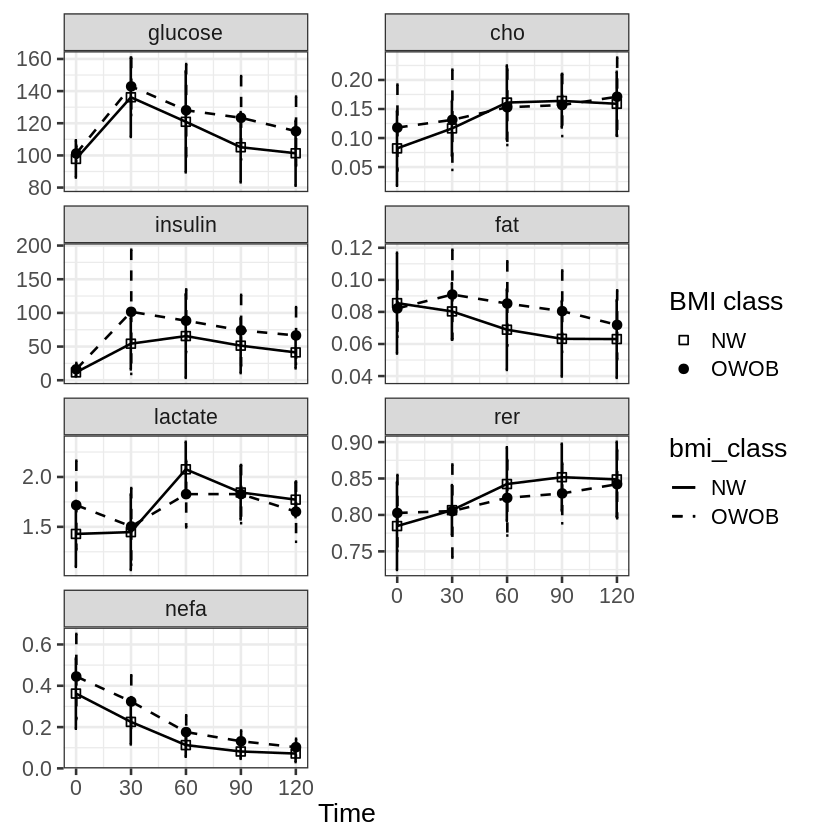

In [35]:
fig1
#Note: This is not a perfect replication of Figure 1
  #Analyses and figure preparation were done in OriginPro (see Methods for details)

## Table 2

In [36]:
#Table 2
#knitr::kable(rer_table)
percent_tables <- gtsummary::tbl_merge(tbls = list(rer_table, tbl_cho1, tbl_cho1b),
                                   tab_spanner = c("RER", "CHO", "CHO with FFM")) %>%
  modify_table_body(~.x %>%
                      arrange(desc(str_detect(label, "%")),
                              desc(str_detect(label, "Time")),
                              desc(str_detect(label, "Fasting Measure"))))

footnote_post_sd <- paste0("A one-unit increase in time represents 30 minutes. ",
                           "\nA 1-SD increase in each covariate corresponds to ",
                           " a 1-SD increase in postprandial RER (",
                           post_sd$post_rer, ") or CHO (", post_sd$post_cho, " g/min).",
                           "\nCovariate SDs: Fasting RER: ", covar_sd$rer_0,
                           "; Fasting CHO: ", covar_sd$cho_0,
                           "; FFM: ", round(covar_sd$ffm, 1),
                           "; See Table 3 for other relevant SDs.")

IRdisplay::display_text("Models are arranged RER, CHO, and CHO w/FFM")
knitr::kable(percent_tables)
IRdisplay::display_text(footnote_post_sd)


Models are arranged RER, CHO, and CHO w/FFM



|**Characteristic** |**Beta** |**95% CI**     |**p-value** |**Beta** |**95% CI**     |**p-value** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|:--------|:--------------|:-----------|:--------|:--------------|:-----------|
|BF% x Time^2       |-0.168   |-0.308, -0.029 |0.019       |-0.169   |-0.314, -0.024 |0.023       |-0.169   |-0.314, -0.024 |0.023       |
|BF% x Time         |0.074    |-0.037, 0.185  |0.187       |0.078    |-0.038, 0.194  |0.182       |0.078    |-0.038, 0.194  |0.182       |
|BF%                |0.652    |0.087, 1.22    |0.026       |0.502    |-0.086, 1.09   |0.090       |0.701    |-0.020, 1.42   |0.056       |
|Time^2             |-0.197   |-0.336, -0.059 |0.006       |-0.210   |-0.354, -0.066 |0.005       |-0.210   |-0.354, -0.066 |0.005       |
|Time               |0.330    |0.220, 0.440   |<0.001      |0.255    |0.140, 0.369   |<0.001      |0.255    |0.140, 0.369   |<0.001      |
|Fasting Measure    |0.80

A one-unit increase in time represents 30 minutes. 
A 1-SD increase in each covariate corresponds to  a 1-SD increase in postprandial RER (0.044) or CHO (0.055 g/min).
Covariate SDs: Fasting RER: 0.055; Fasting CHO: 0.071; FFM: 10.9; See Table 3 for other relevant SDs.

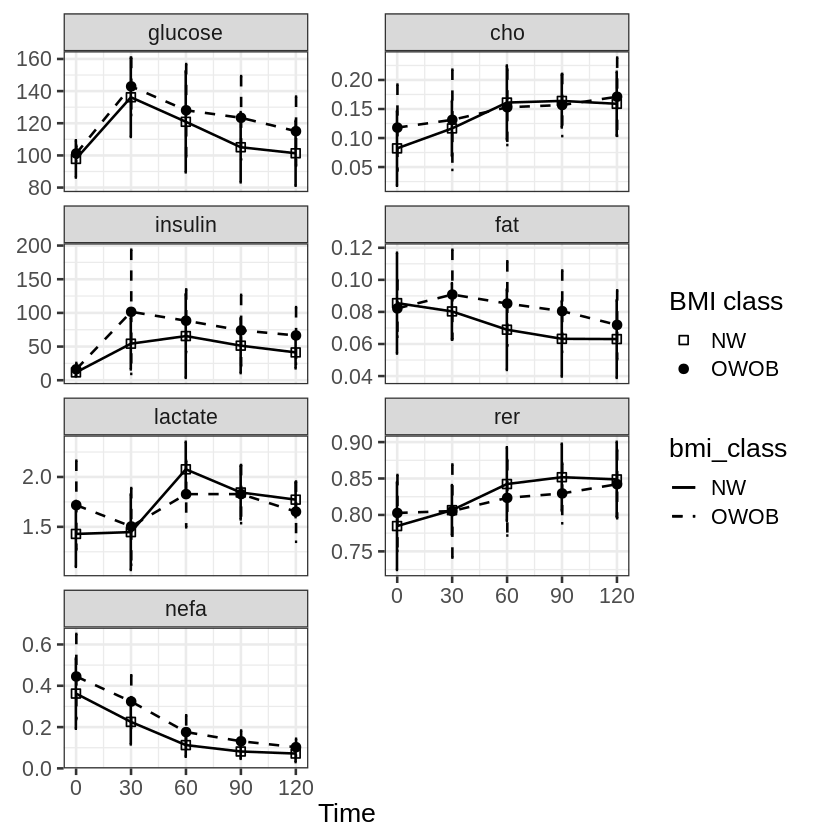

In [37]:
fig1

## Figure 2

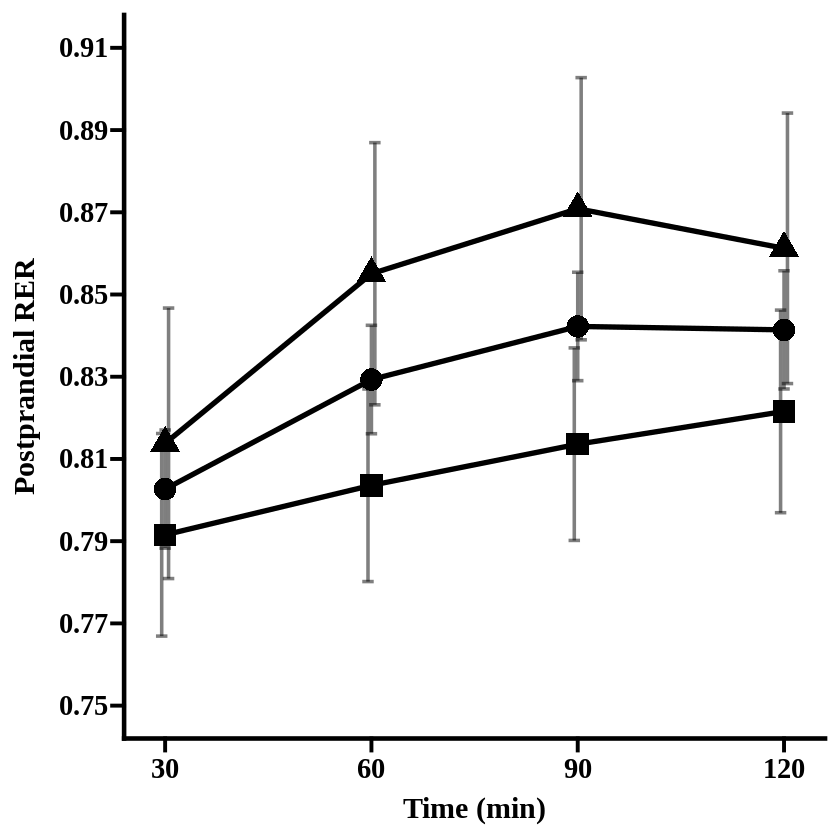

In [38]:
pmod_rer

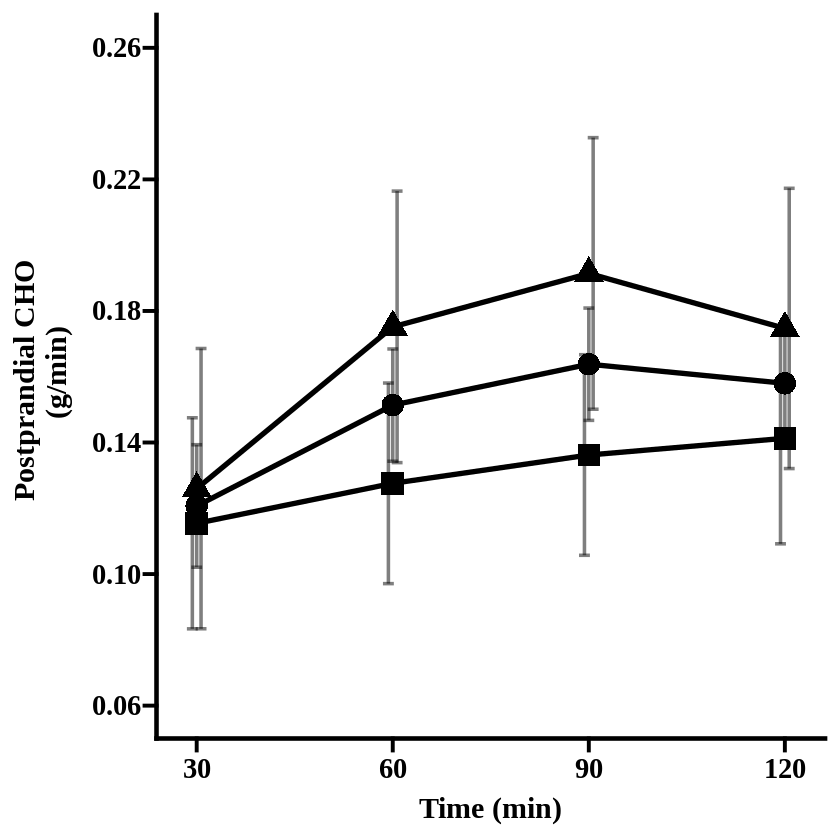

In [39]:
pmod_cho

# Supplemental Results

## Bootstrapping

In [40]:
if(!requireNamespace("lmeresampler", quietly = T)){
install.packages("lmeresampler")
}

#bootstrap model for RER
rer_boot <- lme4::lmer(post_rer ~ I(time^2) * percent_fat + time * percent_fat + rer_0 +
    sex + age_yrs + matsuda + adip_ir_ogtt + vat_vol_trfm + (1 |
    id), data = analysis)

resample_rer <- lmeresampler::bootstrap(rer_boot, .f = fixef, type = "case", B = 1000, resample = c(T, F))
print(resample_rer)

confint(resample_rer) %>%
  filter(type == "perc")



Bootstrap type: case 

Number of resamples: 1000 

                    term    observed    rep.mean         se         bias
1            (Intercept) -0.11340026 -0.14373621 0.33031630 -0.030335948
2              I(time^2) -0.19737844 -0.19500643 0.06782340  0.002372010
3            percent_fat  0.65242678  0.68568271 0.33171480  0.033255928
4                   time  0.33019867  0.33265191 0.06028311  0.002453241
5                  rer_0  0.80301483  0.77626249 0.16110277 -0.026752337
6                   sexM  0.55633390  0.64789464 0.66402667  0.091560733
7                age_yrs -0.09495809 -0.08893332 0.20227539  0.006024771
8                matsuda  0.50456666  0.54912118 0.29394601  0.044554525
9           adip_ir_ogtt  0.20140393  0.26432776 0.30765923  0.062923827
10          vat_vol_trfm -0.50381754 -0.54827113 0.28390400 -0.044453595
11 I(time^2):percent_fat -0.16813467 -0.17038555 0.06118768 -0.002250886
12      percent_fat:time  0.07423099  0.07788892 0.06809602  0.003657927


term,estimate,lower,upper,type,level
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
(Intercept),-0.11340026,-0.74526996,0.54587922,perc,0.95
I(time^2),-0.19737844,-0.32177393,-0.06426771,perc,0.95
percent_fat,0.65242678,0.08714191,1.35603180,perc,0.95
time,0.33019867,0.22013312,0.45364036,perc,0.95
rer_0,0.80301483,0.41704874,1.04439694,perc,0.95
sexM,0.55633390,-0.59859908,1.89749943,perc,0.95
age_yrs,-0.09495809,-0.47389712,0.23333661,perc,0.95
matsuda,0.50456666,0.10853995,1.17036707,perc,0.95
adip_ir_ogtt,0.20140393,-0.25410157,0.83368675,perc,0.95


## Overfitting

In [41]:
#examine potential overfitting by using models with fewer covariates
  #(just sex, Mastuda, and fasting measure)
rer_percent_simple <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_rer",
                   baseline = "rer_0",
                   simple_covars = T,
                   ffm = F)

#effect of BF% on postprandial CHO
cho_percent_simple <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_cho",
                   baseline = "cho_0",
                   simple_covars=T,
                   ffm = F)

summary(rer_percent_simple$mod$mod)
summary(cho_percent_simple$mod$mod)

refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.002"
[1] "Significant interaction. Returning model for plotting"


refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.002"
[1] "Significant interaction. Returning model for plotting"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: quad_form
   Data: analysis

REML criterion at convergence: 209.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.35942 -0.51520  0.02655  0.63650  2.41357 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 0.3476   0.5896  
 Residual             0.2884   0.5370  
Number of obs: 96, groups:  id, 24

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            0.29018    0.21422 23.51642   1.355 0.188410    
I(time^2)             -0.19738    0.06932 68.00000  -2.847 0.005825 ** 
percent_fat            0.21310    0.21827 23.40440   0.976 0.338900    
time                   0.33020    0.05520 68.00000   5.982 9.14e-08 ***
rer_0                  0.73469    0.16125 19.00000   4.556 0.000216 ***
sexM                  -0.39495    0.37524 19.00000  -1.053 0.305763    
matsuda                0.36983    0

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: quad_form
   Data: analysis

REML criterion at convergence: 210.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9718 -0.4427 -0.1251  0.5616  2.9156 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 0.2583   0.5082  
 Residual             0.3128   0.5593  
Number of obs: 96, groups:  id, 24

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)            0.12196    0.20944 24.23059   0.582 0.565728    
I(time^2)             -0.20997    0.07220 68.00000  -2.908 0.004904 ** 
percent_fat            0.30908    0.19862 25.04163   1.556 0.132227    
time                   0.25468    0.05749 68.00000   4.430 3.51e-05 ***
cho_0                  0.70109    0.16752 19.00000   4.185 0.000502 ***
sexM                   0.06232    0.37467 19.00000   0.166 0.869645    
matsuda                0.47570    0.15548 19.

## Table S1



|                              |Overall                 |F                       |M                       |p      |test    |
|:-----------------------------|:-----------------------|:-----------------------|:-----------------------|:------|:-------|
|n                             |27                      |15                      |12                      |       |        |
|sex (%)                       |12 (44.4)               |0 (0.0)                 |12 (100.0)              |<0.001 |        |
|race_eth (%)                  |                        |                        |                        |0.902  |exact   |
|Black                         |7 (25.9)                |4 (26.7)                |3 (25.0)                |       |        |
|hsl                           |1 (3.7)                 |0 (0.0)                 |1 (8.3)                 |       |        |
|other                         |1 (3.7)                 |1 (6.7)                 |0 (0.0)                 |       |        

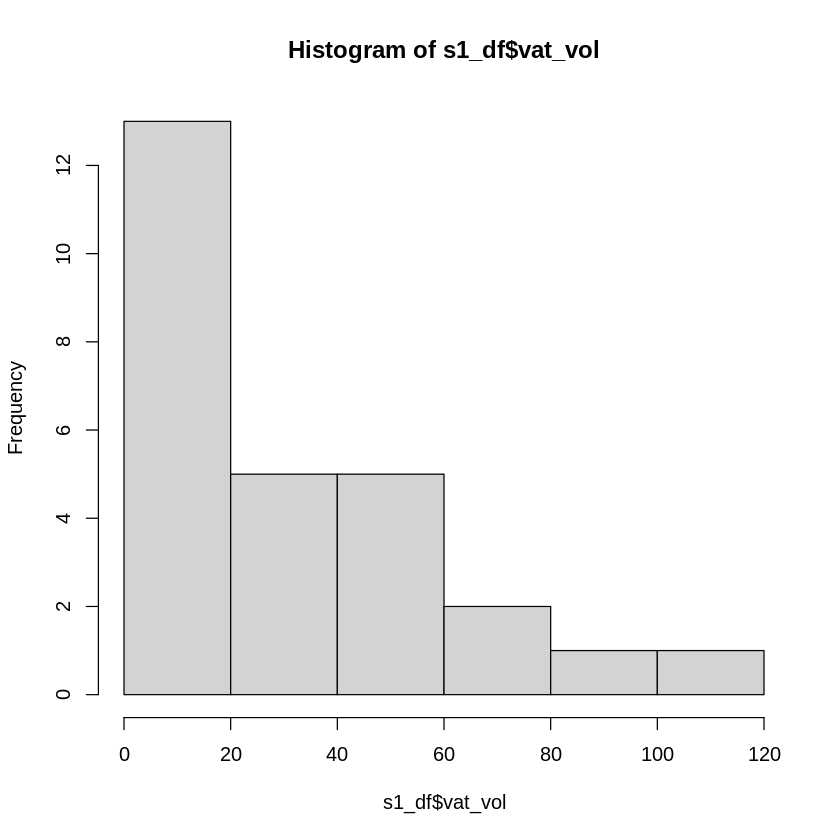

In [42]:
s1_df <- table_data %>%
  select(id, sex, race_eth, age_yrs, ogtt_height_m, ogtt_weight_kg, bmi,
  fat_mass, ffm, percent_fat, vat_vol_trfm, rer_0, cho_0, fat_0,
  vo2max_rel, vo2max_abs) %>%
    rename(vat_vol = vat_vol_trfm) %>%
    left_join(., ree_data[,c("id", "ree")], by = "id") %>%
    select(-id) %>%
    mutate(sex = case_when(
    sex == 1 ~ "F",
    sex == 0 ~ "M"
    ))

    hist(s1_df$vat_vol)

table_s1 <- tableone::CreateTableOne(data = s1_df,
                                 strata = "sex",
                                 addOverall = T,
                                 testNonNormal = wilcox.test,
                                 testNormal = t.test,
                                 includeNA = T)

#adjust list of not normal variables to account for variable renaming
not_norm_s1 <- c("vat_vol", not_norm[2:length(not_norm)])

table_s1 <- print(table_s1,
              nonnormal = not_norm_s1,
              contDigits = 3,
              dropEqual = T,
              printToggle = F,
              exact = "race_eth",
              #varLabels = T, #uses labels from var_label
              #drop0trailing = T, #drops 0 after the decimal mark
              noSpaces = T)

knitr::kable(as.data.frame(table_s1))


## Prep Table S2

In [43]:
#effect of BF% on blood glucose
gluc_mod <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_gluc",
                   baseline = "glucose_0",
                   ffm = F)

round(gluc_mod$mod$pval_int, 3)

#uncomment summary or parameters lines to see model results or CIs, respectively
#summary(gluc_mod$mod$mod)
#parameters::ci_satterthwaite(gluc_mod$mod$mod)

refitting model(s) with ML (instead of REML)



[1] "Linear model selected, p = 0.237"
[1] "No interaction. Returning reduced model"


[1] 0.294

In [44]:
ins_mod <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_ins",
                   baseline = "insulin_0",
                   ffm = F)

round(ins_mod$mod$pval_int, 3)

#uncomment summary or parameters lines to see model results or CIs, respectively
#summary(ins_mod$mod$mod)
#parameters::ci_satterthwaite(ins_mod$mod$mod)


refitting model(s) with ML (instead of REML)



[1] "Linear model selected, p = 0.545"
[1] "No interaction. Returning reduced model"


[1] 0.178

In [45]:
nefa_mod <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_nefa",
                   baseline = "nefa_0",
                   ffm = F)

#summary(nefa_mod$mod$mod)
#parameters::ci_satterthwaite(nefa_mod$mod$mod)

refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0"
[1] "Significant interaction. Returning model for plotting"


In [46]:
lac_mod <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_lac",
                   baseline = "lactate_0",
                   ffm = F)

#summary(lac_mod$mod$mod)
#parameters::ci_satterthwaite(lac_mod$mod$mod)

refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0"
[1] "No interaction. Returning reduced model"


## Table S2

In [47]:
#Supplemental Table 2
tbl_gluc <- gtsummary::tbl_regression(gluc_mod$mod$mod,
                                      show_single_row = "sex",
                                      # pvalue_fun = purrr::partial(style_pvalue, digits = 3),
                                      tidy_fun = custom_ci,
                                      label = list('glucose_0' ~ "Fasting Measure")) %>%
  modify_table_body(~.x %>%
                    mutate(variable = case_when(
                      grepl("_0", variable) ~ "fasting",
                      !grepl("_0", variable) ~ variable,
                    )))

tbl_insulin <- gtsummary::tbl_regression(ins_mod$mod$mod,
                                      show_single_row = "sex",
                                      tidy_fun = custom_ci,
                                      label = list('insulin_0' ~ "Fasting Measure")) %>%
    modify_table_body(~.x %>%
                      mutate(variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )))

tbl_nefa <- gtsummary::tbl_regression(nefa_mod$mod$mod,
                                      tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2",
                                                   "nefa_0" ~ "Fasting Measure"),
                                      show_single_row = "sex") %>%
  modify_table_body(~.x %>%
                      mutate(variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )))

tbl_lac <- gtsummary::tbl_regression(lac_mod$mod$mod,
                                      tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2",
                                                   "lactate_0" ~ "Fasting Measure"),
                                      show_single_row = "sex") %>%
  modify_table_body(~.x %>%
                      mutate(variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )))

footnote_sd <- paste0("A 1-SD increase in each variable corresponds to ",
                            "a 1-SD increase glucose (",
                            round(post_sd$post_gluc, 1), "), insulin (",
                            post_sd$post_ins,
                            "), NEFA (", post_sd$post_nefa,
                            "), or lactate (",
                            round(post_sd$post_lac, 2),
                            ").\nInsulin and NEFA were transformed via natural log for normality.",
                            "\nVariable SDs: BF%: ", round(covar_sd$percent_fat, 1),
                            "; time: ", round(covar_sd$time, 1),
                           "; Fasting glucose: ", round(covar_sd$glucose_0, 1),
                           "; Fasting insulin: ", round(covar_sd$insulin_0, 1),
                           "; Fasting NEFA: ", round(covar_sd$nefa_0, 1),
                           "; Fasting lactate: ", round(covar_sd$lactate_0, 1),";",
                           "\nAge: ", round(covar_sd$age_yrs, 2),
                           "; Matsuda: ", round(covar_sd$matsuda, 1),
                           "; AdipIR(OGTT): ", round(covar_sd$adip_ir_ogtt, 1),
                           "; VAT vol: ", round(covar_sd$vat_vol_trfm, 2),
                           "; Fat-free mass: ", round(covar_sd$ffm, 1))

#print resuls
IRdisplay::display_text("Table for Effect of BF% on Glucose")
knitr::kable(tbl_gluc)

IRdisplay::display_text("\nTable for Effect of BF% on Insulin")
knitr::kable(tbl_insulin)

IRdisplay::display_text("\nTable for Effect of BF% on NEFAs")
knitr::kable(tbl_nefa)

#table is split up by outcome for easier viewing

Table for Effect of BF% on Glucose



|**Characteristic** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|
|Time               |-0.621   |-0.814, -0.427 |<0.001      |
|BF%                |0.802    |-0.021, 1.63   |0.055       |
|Fasting Measure    |0.231    |-0.140, 0.602  |0.206       |
|Sex (Male)         |0.585    |-1.02, 2.19    |0.451       |
|Age                |-0.098   |-0.563, 0.367  |0.660       |
|Matsuda            |0.188    |-0.365, 0.741  |0.482       |
|AdipIR (OGTT)      |0.137    |-0.393, 0.668  |0.591       |
|VAT volume^(1/3)   |-0.014   |-0.790, 0.761  |0.969       |


Table for Effect of BF% on Insulin



|**Characteristic** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|
|Time               |-0.187   |-0.323, -0.050 |0.008       |
|BF%                |0.232    |-0.285, 0.749  |0.355       |
|Fasting Measure    |-0.244   |-0.859, 0.370  |0.412       |
|Sex (Male)         |0.058    |-0.879, 0.995  |0.898       |
|Age                |0.016    |-0.245, 0.278  |0.897       |
|Matsuda            |-0.596   |-1.33, 0.140   |0.105       |
|AdipIR (OGTT)      |0.438    |0.142, 0.735   |0.006       |
|VAT volume^(1/3)   |0.056    |-0.378, 0.489  |0.789       |


Table for Effect of BF% on NEFAs



|**Characteristic** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|
|Time^2             |0.334    |0.177, 0.492   |<0.001      |
|BF%                |0.310    |-0.345, 0.966  |0.333       |
|Time               |-0.955   |-1.08, -0.830  |<0.001      |
|Fasting Measure    |0.210    |-0.142, 0.563  |0.224       |
|Sex (Male)         |1.33     |0.099, 2.57    |0.036       |
|Age                |0.198    |-0.149, 0.544  |0.244       |
|Matsuda            |0.080    |-0.330, 0.491  |0.683       |
|AdipIR (OGTT)      |0.797    |0.359, 1.24    |0.001       |
|VAT volume^(1/3)   |-0.466   |-1.06, 0.128   |0.116       |
|Time^2 * BF%       |0.080    |-0.077, 0.238  |0.313       |
|BF% * Time         |-0.273   |-0.399, -0.147 |<0.001      |

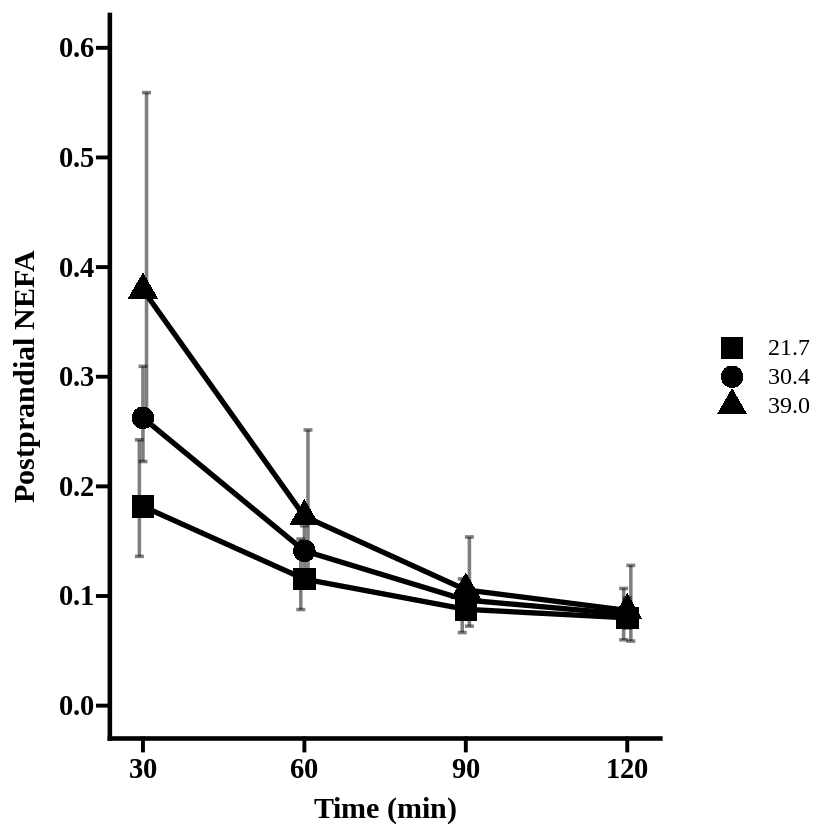

In [48]:
#Figure for NEFA BF% mod
gr <- ref_grid(nefa_mod$mod$mod, cov.keep= c('time', 'percent_fat'),
               at = list(percent_fat = c(-1, 0, 1)),
               nesting = NULL)

emm <- emmeans(gr, spec= c('percent_fat', 'time'), level= 0.95)

emm_mod <- data.frame(summary(emm)) %>%
  select(-df, -SE) %>%
  mutate(across(c(percent_fat, time), ~ (. * ref_sd[cur_column()]) +
           ref_means[cur_column()]),
         # time = time * 30,
         percent_fat = format(round(percent_fat, 1), 1)) %>%
  mutate(across(c(emmean, lower.CL, upper.CL), ~ (. * ref_sd[c("post_nefa")]) +
           ref_means[c("post_nefa")]),
         across(c(emmean, lower.CL, upper.CL), ~ (exp(.))))

#make NEFA model
pmod_nefa <- ggplot(emm_mod,
       aes(y=emmean, x = time, shape = percent_fat)) +
  geom_errorbar(
    # aes(ymin= lower.CL, ymax= emmean, group = percent_fat),
    aes(ymin= lower.CL, ymax= upper.CL, group = percent_fat),
    alpha = 0.5, show.legend = F, width = 5, linewidth = 1,
    position = position_dodge(width = 2, preserve = "single")
    # position = position_nudge(x = 1, y = 0)
  ) +
  geom_line(linewidth = 1.5) +
  geom_point(size = 6) +
  scale_color_manual(values = my_colors, name = NULL) +
  scale_x_continuous(breaks = seq(0,120,30)) +
  labs(x = "Time (min)", y = "Postprandial NEFA") +
  scale_y_continuous(limits = c(0, 0.6),
                     breaks = seq(0, 0.6, 0.1)) +
  scale_shape_manual(name = "BF%",
                     #guide = "none",
               values = c(15,16,17)) +
  ggprism::theme_prism(base_size = 18) +
    theme(text=element_text(family="Times New Roman"))

  pmod_nefa

## Table S3

In [49]:
#effect of body composition on lipid oxidation
lip_percent <- linear_quad_models(adiposity = "percent_fat",
                   outcome = "post_fat",
                   baseline = "fat_0",
                   ffm = F)

gtsummary::tbl_regression(lip_percent$mod$mod,
                                      tidy_fun = custom_ci,
                                      show_single_row = "sex",
                                     label = list('fat_0' ~ "Fasting Measure")) %>%
  modify_table_body(~.x %>%
                      mutate(variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      ))) %>%
                        knitr::kable(.)

refitting model(s) with ML (instead of REML)



[1] "Linear model selected, p = 0.109"
[1] "No interaction. Returning reduced model"




|**Characteristic** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|
|Time               |-0.303   |-0.401, -0.206 |<0.001      |
|BF%                |-0.334   |-0.869, 0.200  |0.203       |
|Fasting Measure    |0.689    |0.410, 0.968   |<0.001      |
|Sex (Male)         |-0.400   |-1.45, 0.651   |0.431       |
|Age                |0.135    |-0.178, 0.449  |0.374       |
|Matsuda            |-0.394   |-0.769, -0.019 |0.041       |
|AdipIR (OGTT)      |-0.217   |-0.564, 0.130  |0.204       |
|VAT volume^(1/3)   |0.457    |-0.056, 0.971  |0.077       |

## Prep Table S4

In [50]:
#Effect of fat mass on postprandial RER
rer_mass <- linear_quad_models(adiposity = "fat_mass",
                   outcome = "post_rer",
                   baseline = "rer_0", ffm = F)

#p-values for BF% x time^2 and BF% x time interactions
round(rer_mass$mod$pval_int, 3)

#effect of fat mass on postprandial CHO
cho_mass <- linear_quad_models(adiposity = "fat_mass",
                   outcome = "post_cho",
                   baseline = "cho_0", ffm = F)

#p-values for BF% x time^2 and BF% x time interactions
round(cho_mass$mod$pval_int, 3)

#effect of fat mass on postprandial CHO while accounting for FFM
norm_cho_mass <- linear_quad_models(adiposity = "fat_mass",
                   outcome = "post_cho",
                   baseline = "cho_0", ffm = T)


#compare final models with and without FFM
comp_norm_cho <- anova(cho_mass$mod$mod, norm_cho_mass$mod$mod) %>%
  data.frame() %>%
  rename(p_val = `Pr..Chisq.`) %>%
  format_chisq_res()


refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.026"
[1] "No interaction. Returning reduced model"


[1] 0.409 0.592

refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.016"
[1] "No interaction. Returning reduced model"


[1] 0.264 0.383

refitting model(s) with ML (instead of REML)



[1] "Quadratic model selected, p = 0.016"
[1] "No interaction. Returning reduced model"


refitting model(s) with ML (instead of REML)



## Table S4

In [51]:
#table for fat mass on RER
tbl_rer2 <- gtsummary::tbl_regression(rer_mass$mod$mod,
                                      tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2"),
                                      show_single_row = "sex") %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(str_detect(label, "Time"))))

#table for fat mass on CHO
tbl_cho2 <- gtsummary::tbl_regression(cho_mass$mod$mod,
                                      tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2"),
                                      show_single_row = "sex") %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(str_detect(label, "Time"))))

#table for fat mass on CHO with FFM
tbl_cho2b <- gtsummary::tbl_regression(norm_cho_mass$mod$mod,
                                       tidy_fun = custom_ci,
                                      label = list('I(time^2)' ~ "Time^2"),
                                      show_single_row = "sex") %>%
  modify_table_body(~.x %>%
                      mutate(label = var_label,
                             variable = case_when(
                        grepl("_0", variable) ~ "fasting",
                        !grepl("_0", variable) ~ variable,
                      )) %>%
                      arrange(desc(str_detect(label, "Time"))))

#create big table of fat mass models
table_s4 <- gtsummary::tbl_merge(tbls = list(tbl_rer2, tbl_cho2, tbl_cho2b),
                                    tab_spanner = c("RER", "CHO", "CHO with FFM")) %>%
  modify_table_body(~.x %>%
                      arrange(desc(str_detect(label, "Time")),
                              desc(str_detect(label, "Fat Mass")),
                              desc(str_detect(label, "Fasting"))))


IRdisplay::display_text("Columns are Effect of Fat Mass on RER, CHO, and CHO w/FFM")
knitr::kable(table_s4)

Columns are Effect of Fat Mass on RER, CHO, and CHO w/FFM



|**Characteristic** |**Beta** |**95% CI**     |**p-value** |**Beta** |**95% CI**     |**p-value** |**Beta** |**95% CI**     |**p-value** |
|:------------------|:--------|:--------------|:-----------|:--------|:--------------|:-----------|:--------|:--------------|:-----------|
|Time^2             |-0.186   |-0.329, -0.042 |0.012       |-0.198   |-0.347, -0.049 |0.010       |-0.198   |-0.347, -0.049 |0.010       |
|Time               |0.325    |0.211, 0.439   |<0.001      |0.249    |0.131, 0.368   |<0.001      |0.249    |0.131, 0.368   |<0.001      |
|Fat Mass           |0.367    |-0.303, 1.04   |0.263       |0.361    |-0.298, 1.02   |0.263       |0.362    |-0.323, 1.05   |0.277       |
|Fasting Measure    |0.761    |0.415, 1.11    |<0.001      |0.732    |0.321, 1.14    |0.002       |0.721    |0.254, 1.19    |0.005       |
|Sex (Male)         |0.194    |-0.829, 1.22   |0.693       |0.309    |-0.744, 1.36   |0.542       |0.283    |-0.894, 1.46   |0.616       |
|Age                |-0.1